#Reverse Image Search Engine

##content


1.   feature_extraction: extract image to the feature from CNN
2.   similarity-search: index features and search for most similar features using nearest neighbor algorithms, and visualizing plots
3.   **reduce-feature-length-with-pca**: experiment with PCA and figure out what is the optimum length of the features to use



##3.reduce-feature-length-with-pca

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import pickle
from tqdm import tqdm, tqdm_notebook
import random
import time
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import PIL
from PIL import Image
from sklearn.neighbors import NearestNeighbors
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams['savefig.dpi'] = 160
matplotlib.rcParams['figure.dpi'] = 160
%matplotlib notebook

Step1: pickle.load and pre-model



In [ ]:
filenames = pickle.load(open('/content/gdrive/MyDrive/Reverse_Image_Search2/filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('/content/gdrive/MyDrive/Reverse_Image_Search3/standard_features-caltech101-resnet.pickle','rb'))
class_ids = pickle.load(open('/content/gdrive/MyDrive/Reverse_Image_Search2/class_ids-caltech101.pickle', 'rb'))

In [ ]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  8677
Number of features per image =  2048


In [ ]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper function that calculates accuracy using the nearest neighbors brute force algorithm
def calculate_accuracy(feature_list):
    num_nearest_neighbors = 5
    correct_prediction = 0
    incorrect_prediction = 0
    neighbors = NearestNeighbors(n_neighbors=num_nearest_neighbors,
                                 algorithm='brute',
                                 metric='euclidean').fit(feature_list)
    start = time.time()
    for i in range(len(feature_list)):
        distances, indices = neighbors.kneighbors([feature_list[i]])
        for j in range(1, num_nearest_neighbors):
            if (classname(filenames[i]) == classname(
                    filenames[indices[0][j]])):
                correct_prediction += 1
            else:
                incorrect_prediction += 1
    end = time.time()
    accuracy = round(
        100.0 * correct_prediction /
        (1.0 * correct_prediction + incorrect_prediction), 2), end - start
    return accuracy

In [ ]:
print("Accuracy on original feature set : ",
      calculate_accuracy(feature_list[:]))

Accuracy on original feature set :  (88.36, 486.15176653862)


step2: PCA start and comparison 

In [ ]:
pca_dimensions = [1, 2, 3, 4, 5, 10, 20, 50, 75, 100, 150, 200]
pca_accuracy = []
pca_time = []

for dimensions in pca_dimensions:
    pca = PCA(n_components=dimensions)
    pca.fit(feature_list)
    feature_list_compressed = pca.transform(feature_list[:])
    # Calculate accuracy over the compressed features
    accuracy, t = calculate_accuracy(feature_list_compressed[:])
    pca_time.append(t)
    pca_accuracy.append(accuracy)
    print("For PCA Dimensions = ", dimensions, ",\tAccuracy = ", accuracy, "%",
          ",\tTime = ", pca_time[-1])

For PCA Dimensions =  1 ,	Accuracy =  17.92 % ,	Time =  3.797163724899292
For PCA Dimensions =  2 ,	Accuracy =  26.82 % ,	Time =  5.589562892913818
For PCA Dimensions =  3 ,	Accuracy =  33.71 % ,	Time =  5.715876817703247
For PCA Dimensions =  4 ,	Accuracy =  40.5 % ,	Time =  6.501161336898804
For PCA Dimensions =  5 ,	Accuracy =  46.38 % ,	Time =  6.596929550170898
For PCA Dimensions =  10 ,	Accuracy =  66.4 % ,	Time =  7.751244783401489
For PCA Dimensions =  20 ,	Accuracy =  79.7 % ,	Time =  8.57813835144043
For PCA Dimensions =  50 ,	Accuracy =  86.8 % ,	Time =  11.628438711166382
For PCA Dimensions =  75 ,	Accuracy =  87.9 % ,	Time =  14.138514995574951
For PCA Dimensions =  100 ,	Accuracy =  88.49 % ,	Time =  16.509891510009766
For PCA Dimensions =  150 ,	Accuracy =  88.69 % ,	Time =  21.954707145690918
For PCA Dimensions =  200 ,	Accuracy =  88.76 % ,	Time =  27.9450421333313


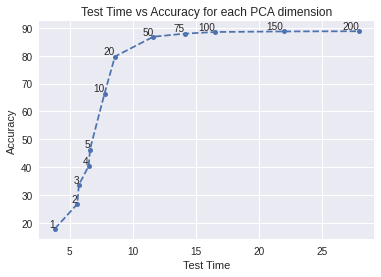

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_time, pca_accuracy, 'o--', markersize=5)
for label, x, y in zip(pca_dimensions, pca_time, pca_accuracy):
    plt.annotate(label, xy=(x, y), ha='right', va='bottom')
plt.title('Test Time vs Accuracy for each PCA dimension')
plt.xlabel('Test Time')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("pca-test_time_vs_acc.pdf", bbox_inches='tight')
f.savefig("pca-test_time_vs_acc.png", bbox_inches='tight')

In [ ]:
f.savefig('pca-test_time_vs_acc.pdf', bbox_inches='tight')
f.savefig('pca-test_time_vs_acc.png', transparent=False, bbox_inches='tight')

A little improvement in accuracy after increasing beyond feature length of 100 dimensions.Hence, 100 would be an ideal feature length for this dataset. This also means that the first 100 dimensions contain the most information about the dataset.

Let's plot the variance of each PCA dimension.

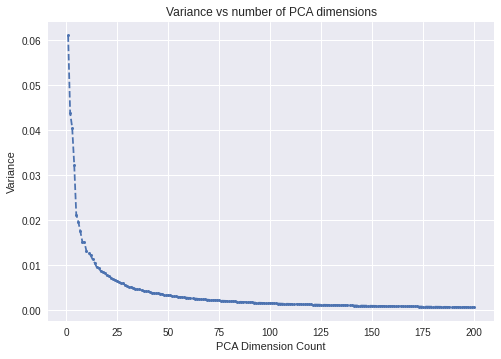

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201), pca.explained_variance_ratio_, 'o--', markersize=3)
plt.title('Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

f.savefig("Variance vs number of PCA dimensions.pdf", bbox_inches='tight')
f.savefig("Variance vs number of PCA dimensions.png", bbox_inches='tight')

after the first 100 dimensions, the additional dimensions don’t add much variance (almost equal to 0) and can be neglected. Without even checking the accuracy it is safe to assume that the PCA with 100 dimensions will be a robust model. 

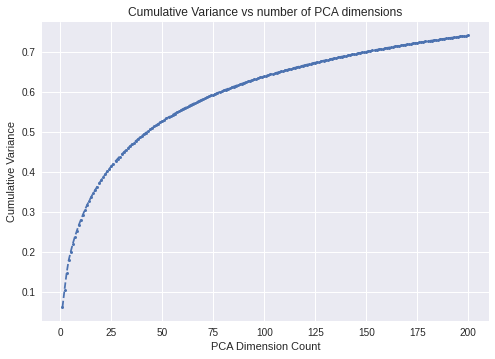

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(range(1, 201),
         pca.explained_variance_ratio_.cumsum(),
         'o--',
         markersize=3)
plt.title('Cumulative Variance vs number of PCA dimensions')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Cumulative Variance')
plt.grid(True)
plt.show()

f.savefig("Cumulative Variance vs number of PCA dimensions.pdf",
          bbox_inches='tight')
f.savefig("Cumulative Variance vs number of PCA dimensions.png",
          bbox_inches='tight')

As expected adding 100 dimensions (from 100 to 200) adds only .1 variance and starts to gradually plateau. For reference, using full 2048 features would result in a cumulative variance of 1.

step3: Plotting the effect of PCA dimension vs Classification Accuracy and time

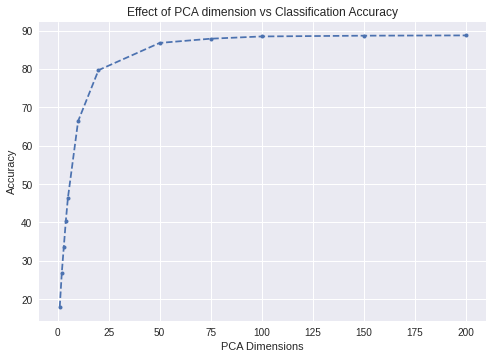

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_accuracy, 'o--', markersize=4)
plt.title('Effect of PCA dimension vs Classification Accuracy')
plt.xlabel('PCA Dimensions')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimension vs Classification Accuracy.pdf",
          bbox_inches='tight')
f.savefig("Effect of PCA dimension vs Classification Accuracy.png",
          bbox_inches='tight')

As visible in the graph, there is little improvement in accuracy after increasing beyond feature length of 100 dimensions. . Hence 100 would be an ideal feature length for this dataset.

We will now plot the effect of number of PCA dimensions vs time.

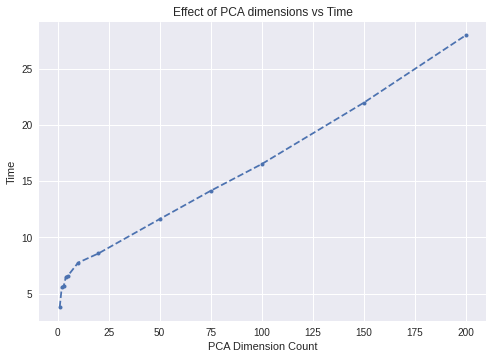

In [ ]:
f = plt.figure()

matplotlib.style.use('seaborn')
plt.plot(pca_dimensions, pca_time, 'o--', markersize=4)
plt.title('Effect of PCA dimensions vs Time')
plt.xlabel('PCA Dimension Count')
plt.ylabel('Time')
plt.grid(True)
plt.show()

f.savefig("Effect of PCA dimensions vs Time.pdf", bbox_inches='tight')
f.savefig("Effect of PCA dimensions vs Time.png", bbox_inches='tight')

PCA dimension 100 can improve accuracy, time compare with oter dimension.
altough demension beyound 100 better but in a litter improve.
PCA with 100 dimensions will be a robust model 

#reduce-feature-length-with-pca -Summary 
- Step1: pickle.load and pre-model
- step2: PCA start and comparison 

Finally, Reverse Image Search use many model and technique in all episode
- feature extraction >>> Similarity searchh >>> PCA(tsne)
- and it can apply to many use case in the real world such as Product seach in retail, recommendation with content base, sidentical signature with few- shot learning and Image captioning  aw well. 

-----------------------------------------------------------------------------
hope you enjoy the engine, thank!